Imports and set-up

In [57]:
# makes figures interactable
%matplotlib notebook

# reloads changes to external files without restarting the notebook
%load_ext autoreload
%autoreload 2

#import math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#import brain area module
from brain import BrainArea
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define parameters of the model and instantiate a brain area and a sequence of five stimuli with them

In [77]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.3

seq_len = 5
stimulus = np.zeros((seq_len, n_inputs))
for i in range(0, seq_len):
    #stimulus[i, i*cap_size : (i+1)*cap_size] = 1.
    for j in range(n_inputs):
        if random.random() > 0.97:
            stimulus[i, j] = 1.

area = BrainArea(n_inputs, n_neurons, cap_size, density, plasticity=1e-1, refraction=False, ref_period=5, ref_penalty=1e2)

Form assemblies for each stimulus by presenting the stimulus to the area 25 times, applying homeostasis after each stimulus.

In [78]:
n_rounds = 25

outputs_form = np.zeros((n_rounds, seq_len, n_neurons))
for j in range(seq_len):
    area.inhibit()
    for i in range(n_rounds):
        area.set_input(stimulus[j])
        area.step()
        outputs_form[i, j] = area.read()
    area.normalize()
area.inhibit()

Sort the neurons of the brain area so that neurons in the same assembly are adjacent

In [79]:
idx = (outputs_form[-1] * np.arange(seq_len, 0, -1)[:, np.newaxis]).sum(axis=0).argsort()[::-1]

Plot the inputs and corresponding activations from the last round of training

<IPython.core.display.Javascript object>


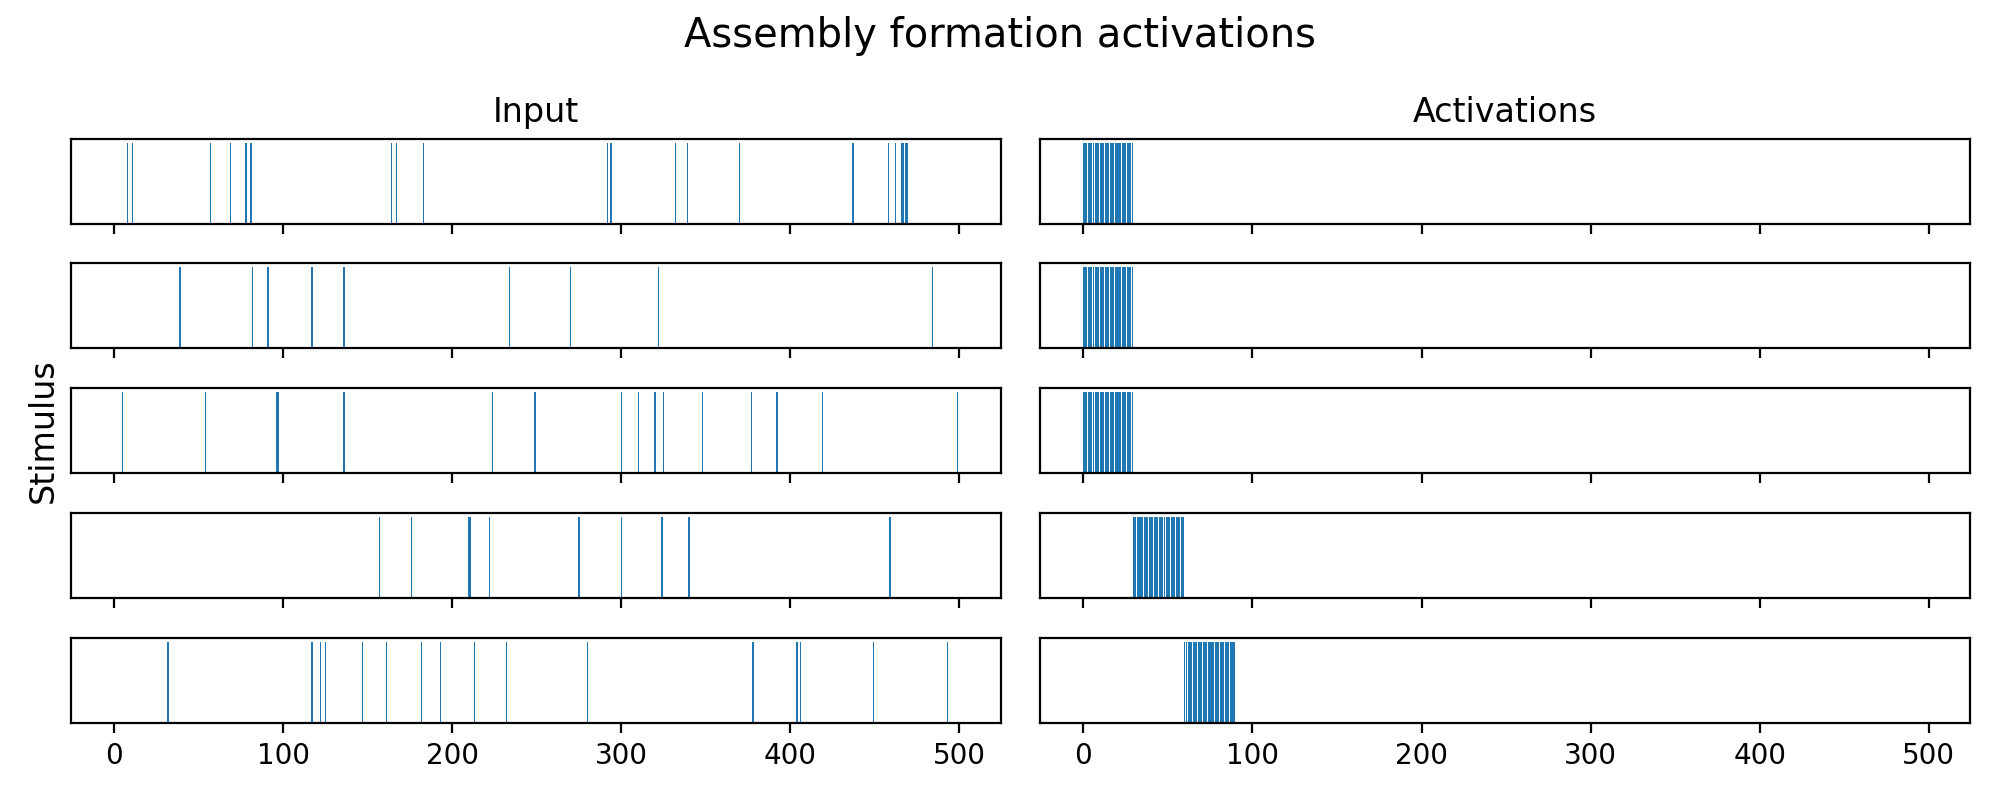

In [80]:
fig, axes = plt.subplots(seq_len, 2, figsize=(10, 4), sharex=True)
for i in range(seq_len):
    axes[i, 0].bar(np.arange(n_inputs // 2), stimulus[i][:n_inputs // 2])
    axes[i, 1].bar(np.arange(n_neurons // 2), outputs_form[-1, i][idx[:n_neurons // 2]])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Stimulus', fontsize='large')
fig.suptitle('Assembly formation activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()

Link consecutive assemblies in the sequence by clamping their neurons to fire

In [51]:
n_rounds = 10
outputs_seq = np.zeros((n_rounds, seq_len, n_neurons))
area.inhibit()
for i in range(n_rounds):
    area.inhibit()
    for j in range(seq_len):
        area.fire(outputs_form[-1, j])
        outputs_seq[i, j] = area.read()
area.inhibit()

Plot the input and sequential activations

<IPython.core.display.Javascript object>


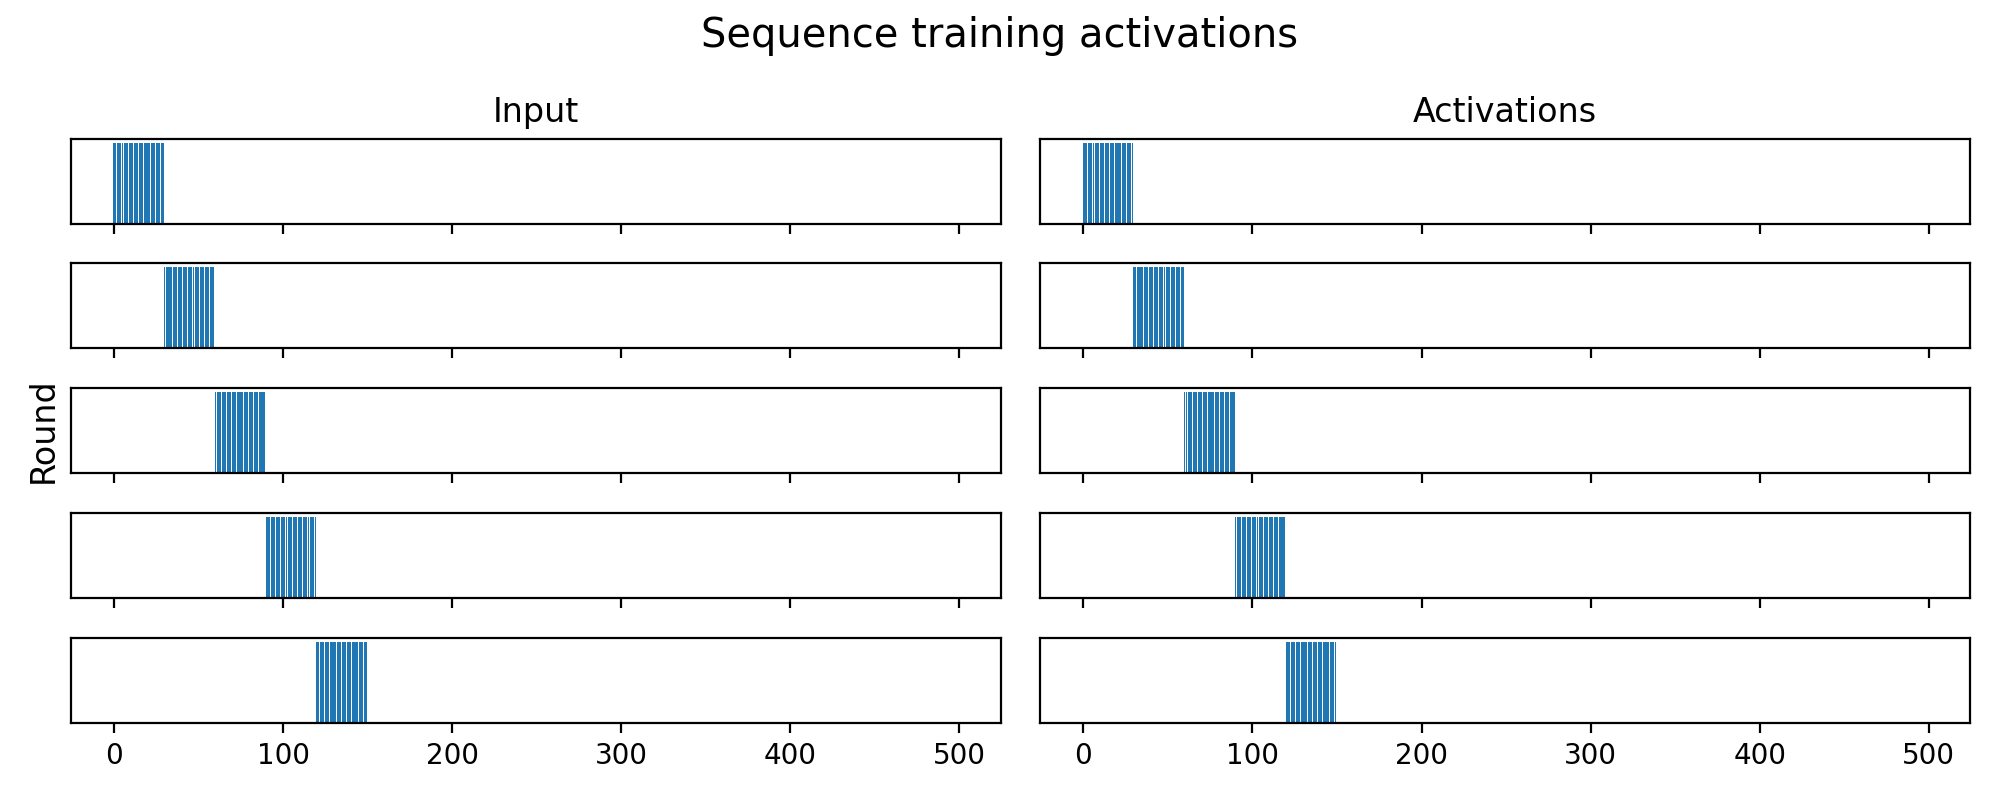

In [52]:
fig, axes = plt.subplots(seq_len, 2, figsize=(10, 4), sharex=True)
for i in range(seq_len):
    axes[i, 0].bar(np.arange(n_inputs // 2), stimulus[i][:n_inputs // 2])
    axes[i, 1].bar(np.arange(n_neurons // 2), outputs_seq[-1, i][idx[:n_neurons // 2]])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Round', fontsize='large')
fig.suptitle('Sequence training activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()

Test recall by firing the first input, with refraction enabled.

In [53]:
area.refraction = True
area.ref_penalty = 1e3
area.inhibit()
n_rounds = seq_len * (area.ref_period + 1)
outputs_rec = np.zeros((n_rounds, n_neurons))
area.inhibit()
for i in range(n_rounds):
    if i == 0:
        area.set_input(stimulus[0])
    area.step(update=False)
    outputs_rec[i] = area.read()
area.inhibit()

<IPython.core.display.Javascript object>


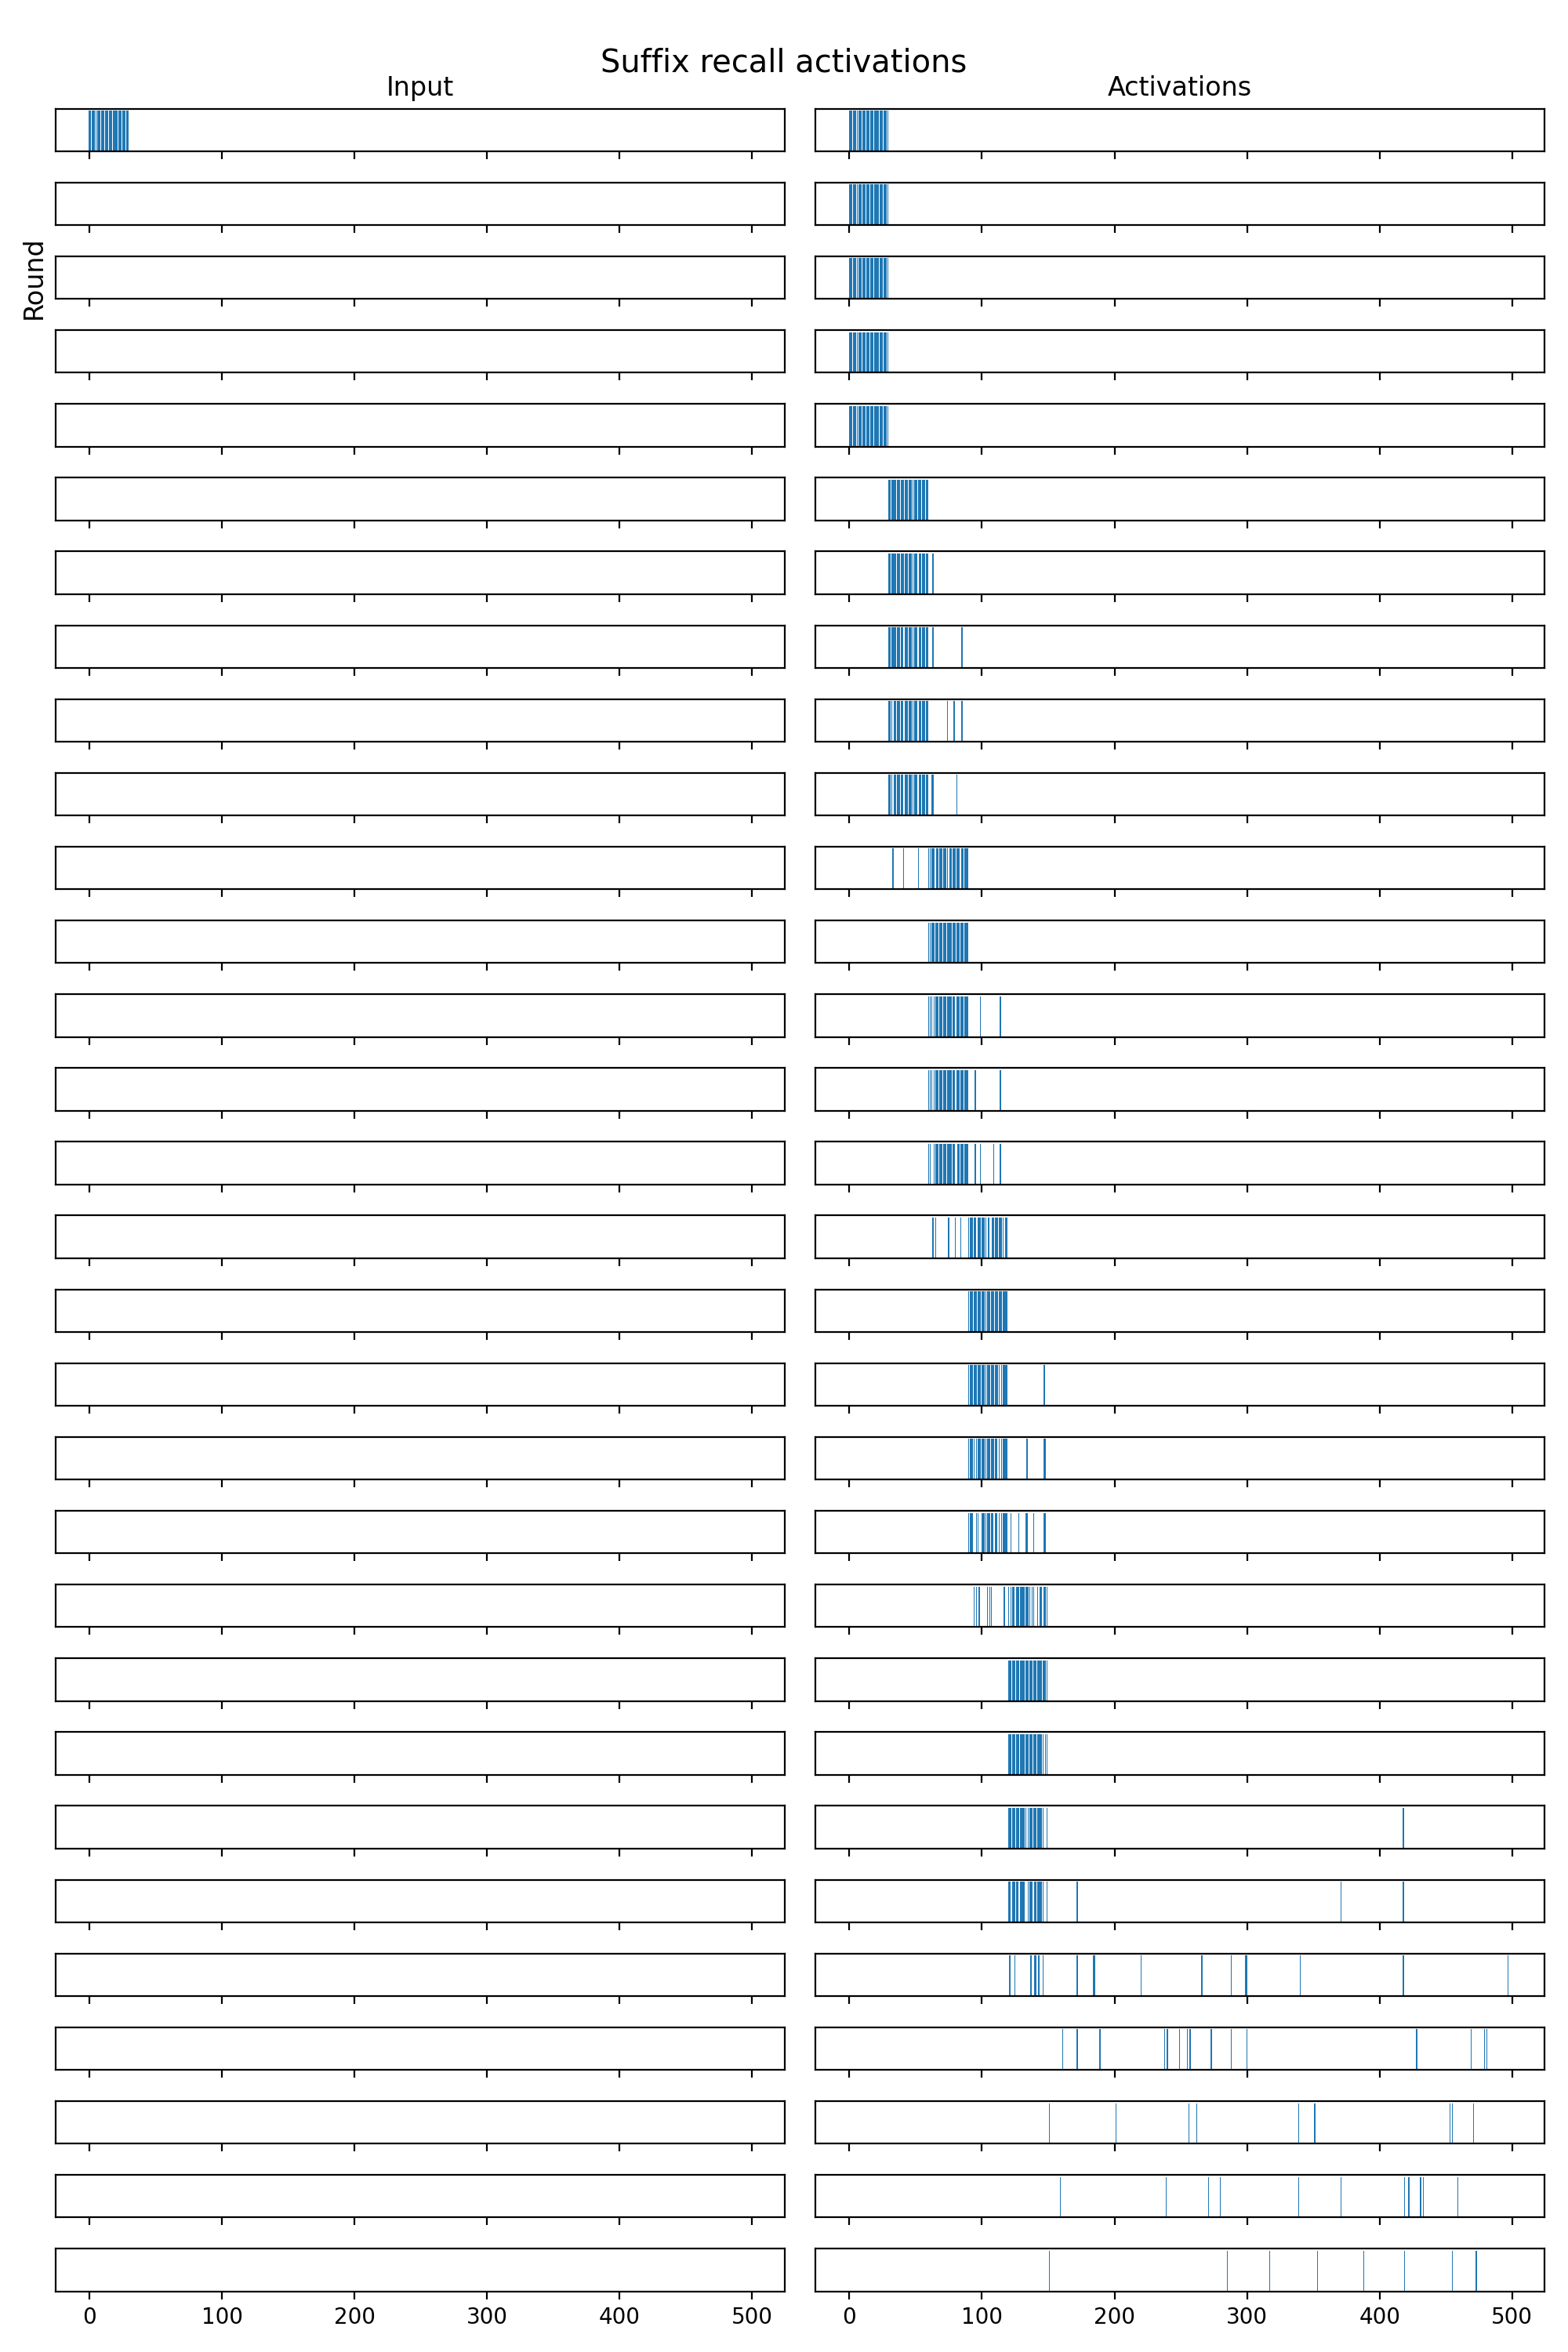

In [54]:
fig, axes = plt.subplots(n_rounds, 2, figsize=(10, 15), sharex=True, sharey=True)
for i in range(n_rounds):
    if i == 0:
        axes[0, 0].bar(np.arange(n_inputs // 2), stimulus[i][:n_inputs // 2])
    else:
        axes[i, 0].bar(np.arange(n_inputs // 2), np.zeros(n_inputs // 2))
    axes[i, 1].bar(np.arange(n_neurons // 2), outputs_rec[i][idx[:n_neurons // 2]])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Round', fontsize='large')
fig.suptitle('Suffix recall activations', fontsize='x-large')
    
for ax in axes.flatten():
    ax.set_yticks([])
    
fig.tight_layout()